In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import datetime

import seaborn as sns
color = sns.color_palette()
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from collections import Counter

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder,PolynomialFeatures,MinMaxScaler,minmax_scale

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor, Pool

from  itertools import combinations

from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import lightgbm as lgb

from sklearn.svm import SVR

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None

import gc

In [34]:
#df_train = pd.read_csv('F:/DataScience/2_flatten_train_v2.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})
#df_test = pd.read_csv('F:/DataScience/2_flatten_test_v2.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})

## Session level

In [2]:
all_data = pd.read_pickle('Prepared_session_data')

In [3]:
all_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109926 entries, 683687 to 988316
Data columns (total 61 columns):
channelGrouping                                 2109926 non-null object
customDimensions                                2109926 non-null object
date                                            2109926 non-null int64
fullVisitorId                                   2109926 non-null object
visitId                                         2109926 non-null int64
visitNumber                                     2109926 non-null int64
device.browser                                  2109926 non-null object
device.operatingSystem                          2109926 non-null object
geoNetwork.city                                 2109926 non-null object
geoNetwork.continent                            2109926 non-null object
geoNetwork.country                              2109926 non-null object
geoNetwork.metro                                2109926 non-null object
geoNetwork.networkDoma

In [4]:
drop_cols = ['date','fullVisitorId', 'totals.transactionRevenue', 'visitId', 'part']

In [5]:
cat_cols = [col for col in all_data.columns 
           if col not in drop_cols and (all_data[col].dtype=='object' or all_data[col].dtype=='bool')
           ]

In [6]:
cat_cols

['channelGrouping',
 'customDimensions',
 'device.browser',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.source',
 'isMobile']

In [40]:
# df_train['totals.transactionRevenue'].fillna(0,inplace=True)
# df_test['totals.transactionRevenue'].fillna(0,inplace=True)

In [7]:
for f in cat_cols:
    all_data[f], indexer = pd.factorize(all_data[f])
    #df_test[f] = indexer.get_indexer(df_test[f])

In [8]:
all_data.head()

,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,device.browser,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.source,part,_month,_day,_weekday,_hour,_year,isMobile,_adContentGMC,_withCampaign,_refPath,_meanHitsPD,_meanHitsPM,_sumHitsPD,_sumHitsPM,_meanPagePD,_meanPagePM,_sumPagePD,_sumPagePM,_meanTosPD,_meanTosPM,_sumTosPD,_sumTosPM,_countNvisPD,_countNvisPM,_sumNvisPD,_sumNvisPM,_ratio_pageviews,_userMean_totals.timeOnSite,_userMean_totals.pageviews,_userMean_totals.hits,_userMean_totals.sessionQualityDim,_userMax_totals.timeOnSite,_userMax_visitNumber,_next_session_1,_next_session_2
683687,0,0,20171128,0000000259678714014,1511912001,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1.0,0,0,0,0,0,train,11,28,1,23,23,0,0,0,0,4.554150,4.086913,305374,845987,3.773720,3.443210,253043.0,712741.0,171.289095,147.007000,11485619.0,30430302.0,67054,206999,50856.0,163607.0,0.000012,64.5,6.5,9.5,6.0,72.0,2,0,-1
680923,0,0,20171128,0000000259678714014,1511914780,2,0,0,0,0,0,0,1,0,0,0.0,0,0,0,0,1.0,0,1,0,0,0,train,11,29,2,0,0,0,0,0,0,4.561762,4.086913,272953,845987,3.784908,3.443210,226470.0,712741.0,169.218250,147.007000,10125174.0,30430302.0,59835,206999,45579.0,163607.0,0.000044,64.5,6.5,9.5,6.0,72.0,2,0,0
379656,0,1,20161020,0000010278554503158,1477029466,1,0,0,1,1,1,1,2,1,1,0.0,0,0,0,0,1.0,0,0,0,0,0,train,10,21,4,5,5,0,0,0,0,4.509202,4.311058,308222,1018246,3.746467,3.573131,256086.0,843952.0,168.480425,163.215674,11516311.0,38550563.0,68354,236194,51083.0,182886.0,0.000031,194.0,8.0,11.0,1.0,194.0,1,0,0
1972778,0,0,20180813,0000018966949534117,1534216634,1,0,0,2,0,0,0,0,0,0,0.0,1,0,0,0,1.0,0,0,0,0,0,test,8,14,1,3,3,0,0,0,0,4.608583,5.281894,320573,1203432,3.812823,4.267169,265220.0,972236.0,171.283381,183.019360,11914472.0,41699314.0,69560,227841,51844.0,171487.0,0.000026,131.0,7.0,7.0,1.0,131.0,1,0,0
168926,0,1,20161130,0000020424342248747,1480578901,1,0,1,3,0,2,2,3,2,2,0.0,0,0,0,0,1.0,0,0,1,1,1,train,12,1,3,7,7,0,0,0,0,4.588103,4.403002,305430,782506,3.798558,3.700407,252870.0,657640.0,167.421992,160.911091,11145282.0,28597280.0,66570,177721,50632.0,132475.0,0.000051,297.0,13.0,17.0,1.0,297.0,1,0,0


In [43]:
# for col in cat_cols:
#     print(col)
#     lbl = LabelEncoder()
#     lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
#     df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
#     df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))


In [29]:
df_train = all_data[all_data['part'] == 'train']
df_test = all_data[all_data['part'] == 'test']

In [30]:
print(df_train.shape)
print(df_test.shape)

(1708337, 61)
(401589, 61)


In [31]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [32]:
folds = get_folds(df=df_train, n_splits=5)

train_features = [_f for _f in df_train.columns if _f not in drop_cols]
print(train_features)
y_reg = df_train['totals.transactionRevenue']
y_time_valid = df_test['totals.transactionRevenue']

importances = pd.DataFrame()
oof_reg_preds = np.zeros(df_train.shape[0])
sub_reg_preds = np.zeros(df_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = df_train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = df_train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'#, categorical_feature=date_cols
        
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(df_test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(y_reg, oof_reg_preds) ** .5

['channelGrouping', 'customDimensions', 'visitNumber', 'device.browser', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.source', '_month', '_day', '_weekday', '_hour', '_year', 'isMobile', '_adContentGMC', '_withCampaign', '_refPath', '_meanHitsPD', '_meanHitsPM', '_sumHitsPD', '_sumHitsPM', '_meanPagePD', '_meanPagePM', '_sumPagePD', '_sumPagePM', '_meanTosPD', '_meanTosPM', '_sumTosPD', '_sumTosPM', '_countNvisPD', '_countNvisPM', '_sumNvisPD', '_sumNvisPM', '_ratio_pageviews', '_userMean_totals.timeOnSite', '_userMean_to

1.4884552645346163

In [35]:
mean_squared_error((y_time_valid), np.log1p(sub_reg_preds)) ** .5

1.6176531922031152

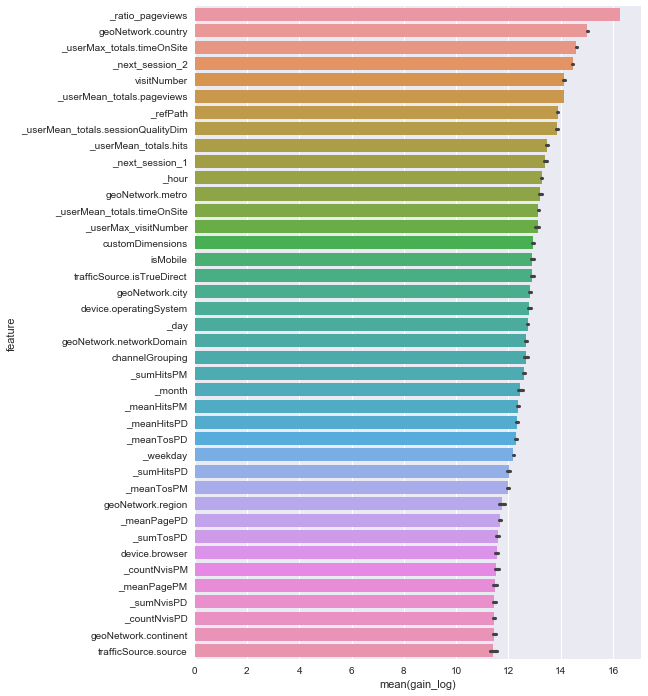

In [34]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False)[:200])

In [43]:
#SAve result 
sess_res_df = pd.DataFrame({"fullVisitorId":df_test['fullVisitorId']})

sess_res_df["PredictedLogRevenue"] = sub_reg_preds
sess_res_df = sess_res_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sess_res_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sess_res_df["PredictedLogRevenue"] = np.log1p(sess_res_df["PredictedLogRevenue"])
#sess_res_df["PredictedLogRevenue"][sess_res_df["PredictedLogRevenue"]<0.1] = 0
sess_res_df.to_csv("solutions/28_11_new_baseline.csv", index=False)

## Visitor level


In [33]:
usr_cat_cols = cat_cols + ['_adContentGMC', '_withCampaign', '_refPath']
usr_num_cols = set(df_train.columns).difference(set(usr_cat_cols + drop_cols + ['_day','_month','_hour','_weekday','_year']))

In [35]:
trn_usr_cat = df_train[usr_cat_cols + ['fullVisitorId']].groupby(['fullVisitorId']).median()
trn_usr_num = df_train[list(usr_num_cols) + ['fullVisitorId']].groupby(['fullVisitorId']).mean()
trn_full_usr = pd.concat([trn_usr_cat,trn_usr_num], axis=1)

In [36]:
test_usr_cat = df_test[usr_cat_cols + ['fullVisitorId']].groupby(['fullVisitorId']).median()
test_usr_num = df_test[list(usr_num_cols) + ['fullVisitorId']].groupby(['fullVisitorId']).mean()
test_full_usr = pd.concat([test_usr_cat,test_usr_num], axis=1)

In [40]:
trn_user_target = df_train[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()
test_user_target = df_test[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()

In [54]:
# trn_full_usr['_usr_maxSessionRevenue'] = df_train[['fullVisitorId','date']].groupby('fullVisitorId').max()
# trn_full_usr['_usr_meanMonthSessions'] = df_train[['fullVisitorId','_month','totals.transactionRevenue']]. \
# groupby(['fullVisitorId','_month']).count().reset_index().groupby('fullVisitorId')['totals.transactionRevenue'].mean()
# test_full_usr['_usr_maxSessionRevenue'] = df_test[['fullVisitorId','totals.transactionRevenue']].groupby('fullVisitorId').max()
# test_full_usr['_usr_meanMonthSessions'] = df_test[['fullVisitorId','_month','totals.transactionRevenue']]. \
# groupby(['fullVisitorId','_month']).count().reset_index().groupby('fullVisitorId')['totals.transactionRevenue'].mean()

In [38]:
all_data['real_date'] = pd.to_datetime(all_data['date'], format="%Y%m%d")

In [62]:
all_data[all_data['part'] == 'test']['real_date'].min()

Timestamp('2018-05-01 00:00:00')

In [69]:
pd.Timestamp('2018-05-01 00:00:00') + pd.DateOffset(months=2)

Timestamp('2018-08-01 00:00:00')

In [46]:
list(periods(all_data[all_data['part'] == 'train']))

[(Timestamp('2016-08-01 00:00:00'), Timestamp('2016-10-01 00:00:00')),
 (Timestamp('2016-09-01 00:00:00'), Timestamp('2016-11-01 00:00:00')),
 (Timestamp('2016-10-01 00:00:00'), Timestamp('2016-12-01 00:00:00')),
 (Timestamp('2016-11-01 00:00:00'), Timestamp('2017-01-01 00:00:00')),
 (Timestamp('2016-12-01 00:00:00'), Timestamp('2017-02-01 00:00:00')),
 (Timestamp('2017-01-01 00:00:00'), Timestamp('2017-03-01 00:00:00')),
 (Timestamp('2017-02-01 00:00:00'), Timestamp('2017-04-01 00:00:00')),
 (Timestamp('2017-03-01 00:00:00'), Timestamp('2017-05-01 00:00:00')),
 (Timestamp('2017-04-01 00:00:00'), Timestamp('2017-06-01 00:00:00')),
 (Timestamp('2017-05-01 00:00:00'), Timestamp('2017-07-01 00:00:00')),
 (Timestamp('2017-06-01 00:00:00'), Timestamp('2017-08-01 00:00:00')),
 (Timestamp('2017-07-01 00:00:00'), Timestamp('2017-09-01 00:00:00')),
 (Timestamp('2017-08-01 00:00:00'), Timestamp('2017-10-01 00:00:00')),
 (Timestamp('2017-09-01 00:00:00'), Timestamp('2017-11-01 00:00:00')),
 (Time

In [39]:
folds = get_folds(df=trn_full_usr[['geoNetwork.country']].reset_index(), n_splits=5)

oof_preds = np.zeros(trn_full_usr.shape[0])
sub_preds = np.zeros(test_full_usr.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = trn_full_usr.iloc[trn_], trn_user_target['totals.transactionRevenue'].iloc[trn_]
    val_x, val_y = trn_full_usr.iloc[val_], trn_user_target['totals.transactionRevenue'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(test_full_usr[trn_full_usr.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
mean_squared_error(trn_user_target['totals.transactionRevenue'], oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.97527	VALID's rmse: 1.97749
[200]	TRAIN's rmse: 1.88499	VALID's rmse: 1.96824
[300]	TRAIN's rmse: 1.8337	VALID's rmse: 1.96477
Early stopping, best iteration is:
[341]	TRAIN's rmse: 1.81405	VALID's rmse: 1.96369
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.97173	VALID's rmse: 2.03624
[200]	TRAIN's rmse: 1.88629	VALID's rmse: 2.008
Early stopping, best iteration is:
[244]	TRAIN's rmse: 1.86294	VALID's rmse: 2.00351
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.98005	VALID's rmse: 1.93628
[200]	TRAIN's rmse: 1.89375	VALID's rmse: 1.91059
[300]	TRAIN's rmse: 1.84612	VALID's rmse: 1.90816
Early stopping, best iteration is:
[336]	TRAIN's rmse: 1.83196	VALID's rmse: 1.90743
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.97791	VALID's rmse: 1.95637
[200]	TRAIN's rmse: 1.89577	VALID's rmse: 1.9502
[

2.0510215710136395

In [47]:
mean_squared_error(test_user_target['totals.transactionRevenue'], sub_preds) ** .5

2.180962136271079

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



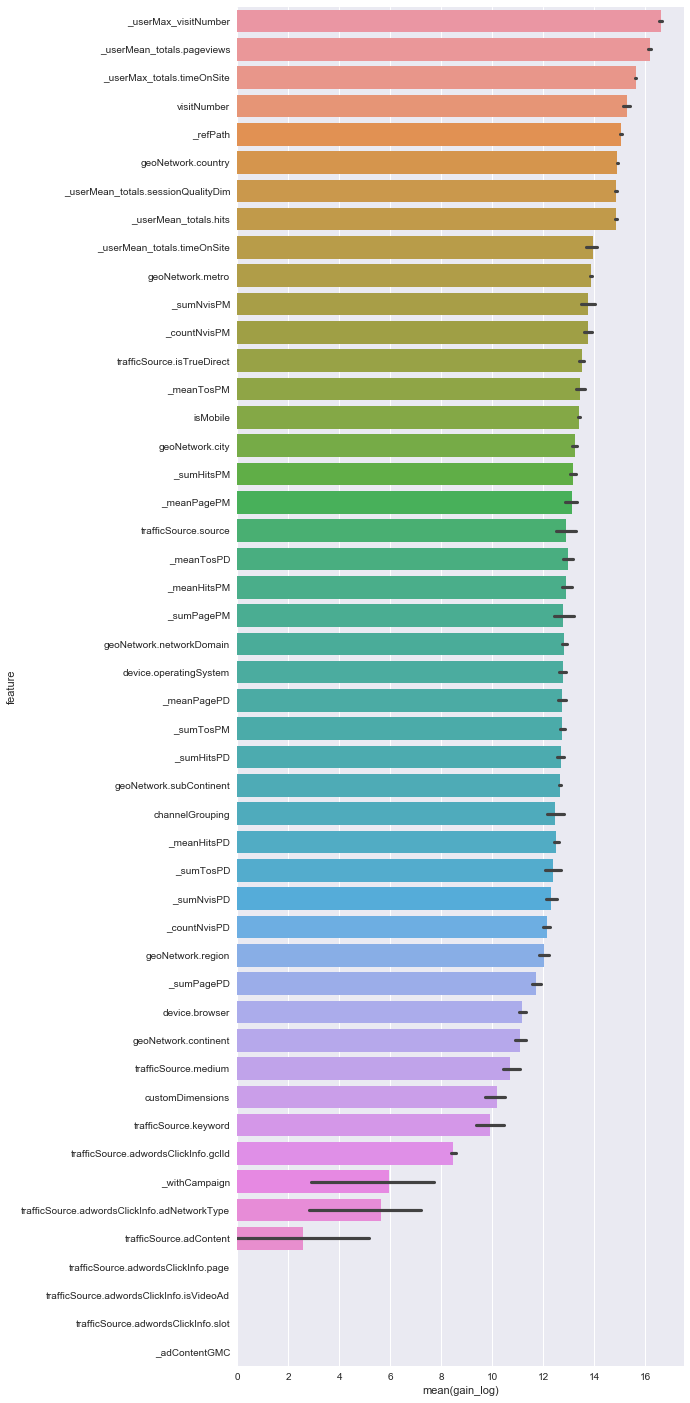

In [43]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

#### Saving to file


In [45]:
test_user_target['PredictedLogRevenue'] = sub_preds
test_user_target[['PredictedLogRevenue']].to_csv('solutions/29_11_USER_baseline.csv', index=True)